# Generation Using Idyoms

In [1]:
using DataFrames, Plots, Random
using Chakra
using Idyoms

## Load Melch

In [2]:
using Melch
Melch.__INIT__("/Users/nick/Dropbox/MelchData")

## Select Nova Dataset

In [3]:
nova = fnd(Melch.id(0),Melch)
nova.description

"Songs and ballads from Nova Scotia, Canada."

## Generate Sequences

In [4]:
melodies = pts(nova)
sequences = [sequence(pts(mel,Melch),Melch) for mel in melodies];

## Define Viewpoints

In [5]:
CPITCH = vp(Melch.CPITCH)
DUR = vp(Melch.DUR)
CPITCH_X_DUR = link(CPITCH,DUR)

Chakra.LinkedViewpoint{Tuple{Int64, Int64}}(Viewpoint[Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:CPITCH, Int64}(), Type[Int64]), Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:DUR, Int64}(), Type[Int64])], DataType[Int64, Int64])

## Generate Views

In [6]:
p_p = [View(seq,CPITCH,CPITCH) for seq in sequences];
d_d = [View(seq,DUR,DUR) for seq in sequences];
p_d = [View(seq,CPITCH,DUR) for seq in sequences];
d_p = [View(seq,DUR,CPITCH) for seq in sequences];
pxd_pxd = [View(seq,CPITCH_X_DUR,CPITCH_X_DUR) for seq in sequences];

## Define Generation Functions

In [7]:
function sample(dist::Idyoms.Distribution{T}) where T
    ps = shuffle(collect(dist))
    a = first.(ps)
    p = cumsum(last.(ps))
    n = rand(Float64)
    q = findfirst(q->n<=q,p)
    return first(ps[q])
end

function generate(ctx::Vector{S},
                  tally::Idyoms.Tally{S,T},
                  seen::Set{T},
                  A::Set{T},
                  B::Idyoms.Smoothing,
                  E::Idyoms.Escape,
                  U::Bool) where {S,T}
    dist = Dict{T,Float64}()
    ords = Dict{T,Int}()
    for e in A
        @views p, o = Idyoms.estimate(e,ctx[1:end],tally,seen,A,B,E,U)
        dist[e] = p
        ords[e] = o
    end

    Idyoms.normalise!(dist)
    
    nxt = sample(dist)
    
    return Prediction(nxt,dist[nxt],ords[nxt],dist)
end

generate (generic function with 1 method)

## Set Parameters

In [8]:
o = Bounded(5) # order bound
b = Backoff() # smoothing technique
e = A() # escape method
u = true # update exclusion

true

## Generate Models

In [9]:
p_p_tally, p_seen = Idyoms.train(p_p,o);
d_d_tally, d_seen = Idyoms.train(d_d,o);
p_d_tally, d_seen = Idyoms.train(p_d,o);
d_p_tally, p_seen = Idyoms.train(d_p,o);
pxd_pxd_tally, pxd_seen = Idyoms.train(pxd_pxd,o);

## Use models to generate new sequences

In [10]:
preds = Prediction{Tuple{Int,Int}}[]
seq = Tuple{Int,Int}[]
for i in 1:100
    p = generate(seq,pxd_pxd_tally,pxd_seen,pxd_seen,b,e,u)
    push!(seq,p.symbol)
    push!(preds,p)
end

## Display Sequence

In [11]:
Idyoms.mean_infcontent(preds)

2.4446112518458283

In [12]:
df = Idyoms.todataframe(1,preds)

Row,SeqID,EventID,Symbol,Order,Prob,IC,H
,Int64,Int64,Tuple…,Int64,Float64,Float64,Float64
1,1,1,"(75, 12)",0,0.00105239,9.89212,5.69385
2,1,2,"(63, 12)",1,0.300004,1.73695,2.93056
3,1,3,"(63, 12)",2,0.75,0.415037,1.8922
4,1,4,"(67, 12)",3,0.75,0.415037,1.70516
5,1,5,"(68, 12)",3,0.0833333,3.58496,1.431
6,1,6,"(70, 12)",4,0.5,0.999999,2.40849
7,1,7,"(72, 12)",2,0.375,1.41504,1.90011
8,1,8,"(63, 24)",3,0.75,0.415037,1.62401
9,1,9,"(63, 12)",4,0.750001,0.415037,1.88998


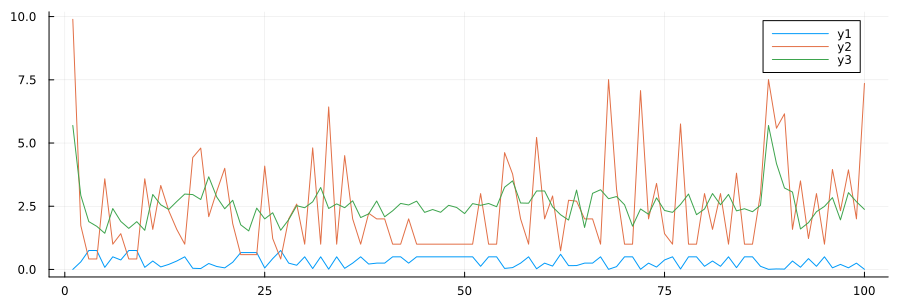

In [13]:
plot(df.Prob)
plot!(df.IC)
plot!(df.H)
plot!(size=(900,300))

In [14]:
using MIDI, Dates
function generatemidifile(xs::Vector{Tuple{Int,Int}},name::String)
    tpq = 960
    notes = Note[]
    pos = 0
    for pair in xs
        pitch = pair[1]
        velocity = 100
        dur = Int(tpq*pair[2]/24)
        
        note = Note(pitch,100,pos,dur)
        
        push!(notes,note)
        pos+=dur
    end
    track = MIDITrack()
    addnotes!(track, notes)
    
    midi = MIDIFile(0, tpq, [track])
    cd(@__DIR__)
    save(name, midi)
end

generatemidifile (generic function with 1 method)

In [15]:
generatemidifile(seq,"example.mid")

MIDIFile (format=0, tpq=960) with 1 tracks